# Discrete sampling
In the last problem of the first session we sampled with given probabilities using prefix sums and binary search. The sampling code is the bottleneck of the whole process, its running times is 3 times higher than the code for uniform probabilities, and the difference would only increase for larger number of outcomes. In the next two problems we discuss two simple, but powerful techniques one can use to sample in time $O(1)$.

**Problem 2a.** Consider the problem of sampling with known probabilities $p_1,\ldots,p_d$. Suppose that you have a black-box that samples with probabilities $q_1,\ldots,q_d$ that are close to $p_1,\ldots,p_d$, say
$$ \forall_{i=1,\ldots,n} p_i \le (1+\varepsilon)q_i.$$

* How can you use this black-box to sample with probabilities $p_1,\ldots,p_d$? It is expected, that the running time of the algorithm would be non-deterministic.
* Prove that your algorithm is correct.
* Implement the algorithm and use it to give a faster implementation for **Problem 1c**.

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import random
import numpy as np
import time 

file = np.loadtxt('us_births_69_88.csv', skiprows=1, delimiter=',', dtype=int)


birth_data = np.array(file[:,2])
days_len = len(birth_data)

probs = birth_data/np.sum(birth_data)

max_prob = np.amax(probs)
min_prob = np.amin(probs)

def sample():
    while True:
        pick = random.randint(1, days_len)
        m = random.uniform(0, 1) * max_prob
        if m < probs[pick - 1]:
            return pick

def find_first_duplicate():
    date_set = set()
    
    rand = sample()
    while rand not in date_set:
        date_set.add(rand)
        rand = sample()
        
    return len(date_set) + 1

n = xrange(0, 10**5)

time_begin = time.time()

results = [find_first_duplicate() for i in n]

time_stop = time.time()

plt.hist(results, bins=range(min(results), max(results) + 1, 1))
plt.show()

print(str(time_stop - time_begin))

<Figure size 640x480 with 1 Axes>

4.18873405457


**Problem 2b.** One of the reasons this implementation is not significantly faster than the one in **Problem 1c** , apart from $d$ being rather small, is that we are using Python's interpreter a bit too much, and Python is slow. One way around this is usually to use a library function - **searchsorted** is much faster than an equivalent code implemented in pure Python. But even if the functionality you need is not implemented in a lower level language as
a library function, there is still hope. You can try to implement it using optimized array algebra, for example using **numpy**. In this problem, your task is to rewrite the previous algorithm, so that the amount of *looping* is reduced to a minimum necessary. In particular, you should create a *vectorized* version of random dates generation (in bulk), while the actual search for duplicates remains a loop with a **set**. Here are some useful tips:
   * You can perform arithmetic, comparisons, etc. on **numpy** arrays.
   * You can generate whole **numpy** arrays of random numbers at once.
   * You can even perform parallel look-up like in the example below.

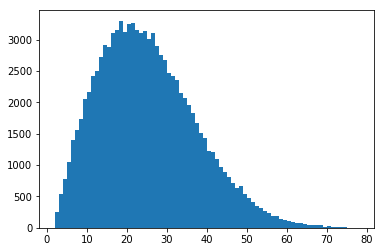

0.78769493103


In [2]:
iterations = 10**5
gen = 80

def lookup_repetition(arr, ret):
    res = []
    for i in xrange(0, len(arr)):
        res.append(lookup_repetition_in_row(arr[i], ret[i]))
    return res

def lookup_repetition_in_row(row, ret_row):
    date_set = set()
    
    for i in row[ret_row]:
        if i not in date_set:
            date_set.add(i)
        else:
            break
    
    return len(date_set) + 1

time_begin = time.time()

dates = np.random.randint(0, days_len, (iterations, gen))
uni = np.random.uniform(0, 1, (iterations, gen)) * max_prob

ret = uni < probs[dates]

results = lookup_repetition(dates, ret)

time_stop = time.time()

plt.hist(results, bins=range(min(results), max(results) + 1, 1))
plt.show()

print(str(time_stop - time_begin))


**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.

In [3]:
#using the "Robin Hood" algorithm, for reference see http://www.robertowor.com/csci4151/lecture3.htm
def square(arr): 
    buckets = np.array(arr, dtype='f')
    v = np.mean(arr)
    
    donors = np.arange(len(arr))
    p = np.full_like(buckets, v)
    
    while np.any(buckets < v):
        index_min = np.argmin(buckets)
        index_max = np.argmax(buckets)
        
        p[index_min] = buckets[index_min]
        donors[index_min] = index_max
        
        buckets[index_max] = buckets[index_max] - (v - buckets[index_min])
        buckets[index_min] = v

    return donors, p


def lookup_repetition(arr):
    result = []
    
    for i in arr:
        result.append(lookup_repetition_in_row(i))
        
    return result

def lookup_repetition_in_row(row):
    date_set = set()
    
    for i in row:
        if i not in date_set:
            date_set.add(i)
        else:
            break
    
    return len(date_set) + 1

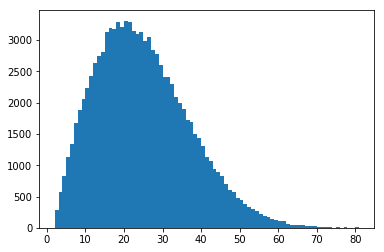

0.784898996353


In [4]:
iterations = 10**5
gen = 80 #judging from the former results, 80 is about right

time_begin = time.time()

dates = np.random.randint(0, days_len, (iterations, gen))
uni = np.random.uniform(0, 1, (iterations, gen)) * max_prob

donors, boundaries = square(probs)

donees_mapping = uni < boundaries[dates]
donors_mapping = np.invert(donees_mapping)

dates[donors_mapping] = donors[dates[donors_mapping]]

results = lookup_repetition(dates)

time_stop = time.time()

plt.hist(results, bins=range(min(results), max(results) + 1, 1))
plt.show()

print(str(time_stop - time_begin))



**Problem 2d.** Show that the frequency histogram for empirical birthday frequencies can actually be computed exactly, and implement your idea. To this end, design a recurence relation using conditional probabilities and use dynamic programming.

**BONUS**. An alternative plotting library: plotly